In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from glob import glob
import pandas as pd
import pickle
import random
from PIL import Image
from glob import glob
import re
#from adjustText import adjust_text
import seaborn as sns
#import statannot
from statannotations.Annotator import Annotator
import argparse
#import torch
import wandb
import sys
from functools import reduce
import torch
import math
import io
import colorcet as cc
from adjustText import adjust_text
sys.path.append('../../modified_medsam_repo')
from MedSAM_HCP.dataset import MRIDataset_Imgs, load_datasets, LabelConverter
#sys.path.append('./modified_medsam_repo')

# Init stuff

In [2]:
sns.set_style("whitegrid")
palette = sns.color_palette("Dark2")

In [3]:
df_hcp = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/darts_name_class_mapping_processed.csv')
label_converter = LabelConverter(df_hcp, df_desired)

# Load result files and create merged dataframe

In [4]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

def proc_pattern_for_eval_result_load(pattern):
    files = glob(pattern)
    listo = []
    for file in files:
        label_num = int(file.split('/')[-1].split('label')[1].split('.pkl')[0])
        
        #stuff = pd.read_pickle(file)
        with open(file, 'rb') as fileo:
            stuff = CPU_Unpickler(fileo).load()
        this_list = [label_num, stuff['dice_sensitivity'].item(), stuff['dice_specificity'].item(), stuff['overall_dice'].item()]
        this_arr = np.array(this_list).reshape((1, 4))
        listo.append(this_arr)

        

    combined = np.concatenate(listo, axis = 0)
    df = pd.DataFrame(combined, columns = ['label_number', 'dice_sensitivity', 'dice_specificity', 'overall_dice'])
    df = df.sort_values('label_number').reset_index(drop=True)

    return df

def load_and_make_into_df(path):
    df = pd.read_pickle(path)
    df = pd.DataFrame(df)
    df = df.rename({'label_numbers': 'label_number'}, axis=1)
    df = df.reset_index(drop=True)
    return df


In [5]:
singletask_unet = proc_pattern_for_eval_result_load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/unet_retrain_all_labels_9-9-24/test/*/*/at_least_100/eval_singletask_unet_test_label*.pkl')
singletask_medsam = proc_pattern_for_eval_result_load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/medsam_retrain_dice_11-1-24/test/*/*/at_least_100/eval_singletask_unprompted_test_label*.pkl')
singletask_medsam_yolo = proc_pattern_for_eval_result_load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/medsam_yolo_retrain_dice_11-18-24/test/*/*/at_least_100_pixels/*.pkl')

#singletask_unet = load_and_make_into_df('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/unet_retrain_all_labels_9-9-24/val/combined_at_least_100.pkl')
#singletask_medsam = load_and_make_into_df('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/medsam_retrain_dice_11-1-24/val/combined_at_least_100.pkl')
#singletask_medsam_yolo = load_and_make_into_df('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/medsam_yolo_retrain_dice_11-18-24/val/combined_at_least_100.pkl')

# this one is broken:
singletask_medsam_yolo_untrained = load_and_make_into_df('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/singletask_untrained_medsam_yolo_10-22-24/val/combined_val.pkl')

# fill in missing labels for singletask_medsam_yolo
dicto = {'dice_sensitivity':[np.nan]*4, 'dice_specificity':[1.0]*4, 'overall_dice':[np.nan]*4, 'label_number': [3,18,22,33]}
append_df = pd.DataFrame(dicto)
singletask_medsam_yolo = pd.concat([singletask_medsam_yolo, append_df], ignore_index=True)




In [6]:
# apply some steps before merging the dataframes
dict_df = {'singletask_unet': singletask_unet, 'singletask_medsam': singletask_medsam, 'singletask_medsam_yolo': singletask_medsam_yolo}

for key in dict_df.keys():
    dfo = dict_df[key].copy()
    dfo = dfo.rename(
        {
            'dice_sensitivity': 'dice_sensitivity_' + key,
            'dice_specificity': 'dice_specificity_' + key,
            'overall_dice': 'overall_dice_' + key,
        }, 
        axis=1
    )

    dict_df[key] = dfo

# merge to create wide dataframe
df_merged = reduce(lambda left,right: pd.merge(left,right,on=['label_number'],
        how='outer', sort=True), list(dict_df.values()))

# create long dataframe from wide
col_list = ['label_number'] + [x for x in df_merged.columns if x.startswith('dice_sensitivity')]
tmp = df_merged[col_list]
df_long = tmp.melt(id_vars = col_list[0], value_vars = col_list[1:],
    var_name = 'method', value_name = 'dice_score')
df_long['method'] = [x.split('dice_sensitivity_')[1] for x in df_long['method']]


# Plots

## Main Analysis

In [4]:
# set color scheme
my_colors = {'MedSAM': palette[0], 'MedSAM + YOLO': palette[1], 'UNet': palette[2], 'MedSAM Oracle': palette[3]}

### Box-plot over all classes

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MedSAM vs. MedSAM + YOLO: t-test paired samples, P_val:1.660e-01 t=1.396e+00
MedSAM + YOLO vs. UNet: t-test paired samples, P_val:1.244e-08 t=-6.253e+00
MedSAM vs. UNet: t-test paired samples, P_val:1.088e-28 t=-1.620e+01


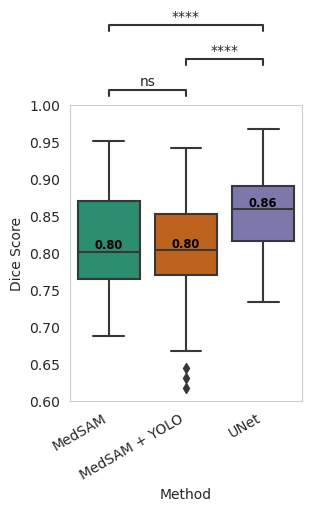

In [58]:
main_analysis_df = df_long.copy()

# figure
fig, axs = plt.subplots(constrained_layout=True, figsize = (3,5))

# make method names more readable
mapper = {
    'singletask_medsam_yolo': 'MedSAM + YOLO', 
    'singletask_medsam': 'MedSAM', 
    'singletask_unet': 'UNet'
}
main_analysis_df['method'] = [mapper[x] for x in main_analysis_df['method']]

# set order
order = ['MedSAM', 'MedSAM + YOLO', 'UNet']

# subset
subdf = main_analysis_df[main_analysis_df['method'].isin(order)].reset_index(drop=True)

# plot
box_plot = sns.boxplot(data = subdf,
            x = 'method',
            y = 'dice_score',
            order = order,
            palette = my_colors,
            ax = axs
)
#axs.tick_params(axis='x', labelrotation=45)
for label_txt in box_plot.get_xticklabels():
    label_txt.set_rotation(30)  
    label_txt.set_ha('right')


medians = subdf.groupby('method')['dice_score'].median().reindex(index = order)
vertical_offset = .005 * subdf['dice_score'].median()

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,f'%s' % str('%.2f' % medians[xtick]), 
            horizontalalignment='center',size='small',color='black',weight='semibold')
axs.grid(False)


axs.set_ylabel('Dice Score')
axs.set_xlabel('Method')

# add statistical tests
annotator = Annotator(axs, 
    pairs = [
        (order[0], order[1]),
        (order[1], order[2]),
        (order[0], order[2])
    ], 
    data=subdf, 
    x='method', 
    y='dice_score', 
    order=order
)
axs.set_ylim(0.6,1)

annotator.configure(test='t-test_paired', text_format='star', loc='outside')
annotator.apply_and_annotate()  

fig.savefig('/gpfs/home/kn2347/figs/main_analysis_boxplot.pdf', dpi=300)

In [72]:
singletask_medsam[:10]

,label_number,dice_sensitivity,dice_specificity,overall_dice
0,1.0,0.907346,0.985344,0.953637
1,2.0,0.905534,0.994963,0.987182
2,3.0,NaN,0.975377,0.975377
3,4.0,0.858360,0.992855,0.979113
4,5.0,0.905636,0.993878,0.975435
5,6.0,0.909590,0.995841,0.989012
6,7.0,0.923553,0.996700,0.989866
7,8.0,0.888234,0.996153,0.987306
8,9.0,0.745143,0.993814,0.986688
9,10.0,0.951098,0.991195,0.991147


### Crossplot

In [87]:
plotdf = df_merged[['label_number', 'dice_sensitivity_singletask_unet', 'dice_sensitivity_singletask_medsam']].copy()
plotdf['label_number'] = [label_converter.compressed_to_name(x).item() for x in plotdf['label_number']]
label_info = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/label_info.csv')
plotdf = plotdf.merge(label_info, how='left', on='label_number') # now has side, name_without_side, group

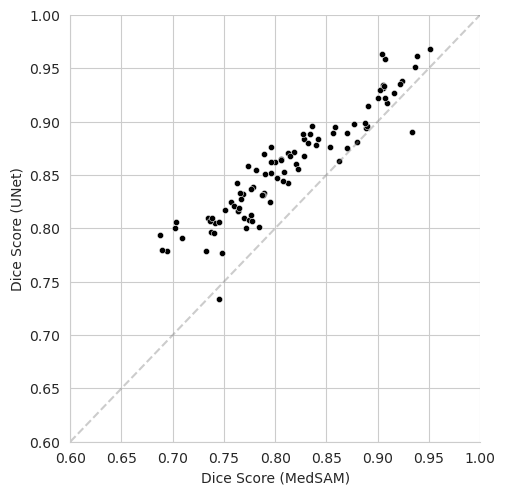

In [96]:

myplot = sns.relplot(plotdf, x = 'dice_sensitivity_singletask_medsam', y = 'dice_sensitivity_singletask_unet', s=20, color='black')
plt.xlim(0.6,1)
plt.ylim(0.6,1)
plt.axline((.3, .3), slope=1, linestyle = '--', color = 'gray', alpha = .4)
plt.xlabel('Dice Score (MedSAM)')
plt.ylabel('Dice Score (UNet)')
'''
texts = [plt.text(
    plotdf.loc[i, 'dice_sensitivity_singletask_medsam'], 
    plotdf.loc[i, 'dice_sensitivity_singletask_unet'],
    plotdf.loc[i, 'name_without_side'], ha='center', va='center', size=5) for i in range(len(plotdf))
]
'''
plt.savefig('/gpfs/home/kn2347/figs/unet_medsam_crossplot.pdf', dpi=300)

### Per-class performance

In [175]:
order_descending = df_long.dropna(how='all').groupby('label_number').agg({'dice_score':'median'}).sort_values('dice_score', ascending=False).dropna().index.astype(int).tolist()
order_descending = [label_converter.compressed_to_name(x).item() for x in order_descending]
order_descending

['3rd-Ventricle',
 'Brain-Stem',
 '4th-Ventricle',
 'Left-Caudate',
 'Right-Caudate',
 'Right-Thalamus-Proper',
 'Left-Thalamus-Proper',
 'Right-Cerebellum-Cortex',
 'Left-Cerebellum-Cortex',
 'Left-Lateral-Ventricle',
 'Right-Putamen',
 'Left-Cerebral-White-Matter',
 'Right-Cerebral-White-Matter',
 'Right-Lateral-Ventricle',
 'Right-Hippocampus',
 'Left-Hippocampus',
 'CC_Anterior',
 'Left-Amygdala',
 'Left-Putamen',
 'Right-Amygdala',
 'Left-Accumbens-area',
 'Right-VentralDC',
 'Right-Pallidum',
 'Left-VentralDC',
 'Right-Accumbens-area',
 'Left-Cerebellum-White-Matter',
 'Right-Cerebellum-White-Matter',
 'CSF',
 'ctx-lh-insula',
 'ctx-lh-superiorfrontal',
 'ctx-rh-superiorfrontal',
 'ctx-lh-precentral',
 'ctx-rh-precentral',
 'ctx-lh-lateralorbitofrontal',
 'ctx-rh-lateralorbitofrontal',
 'ctx-rh-insula',
 'ctx-rh-rostralmiddlefrontal',
 'ctx-lh-rostralmiddlefrontal',
 'ctx-rh-medialorbitofrontal',
 'ctx-rh-caudalanteriorcingulate',
 'ctx-rh-parahippocampal',
 'ctx-lh-precuneus',
 

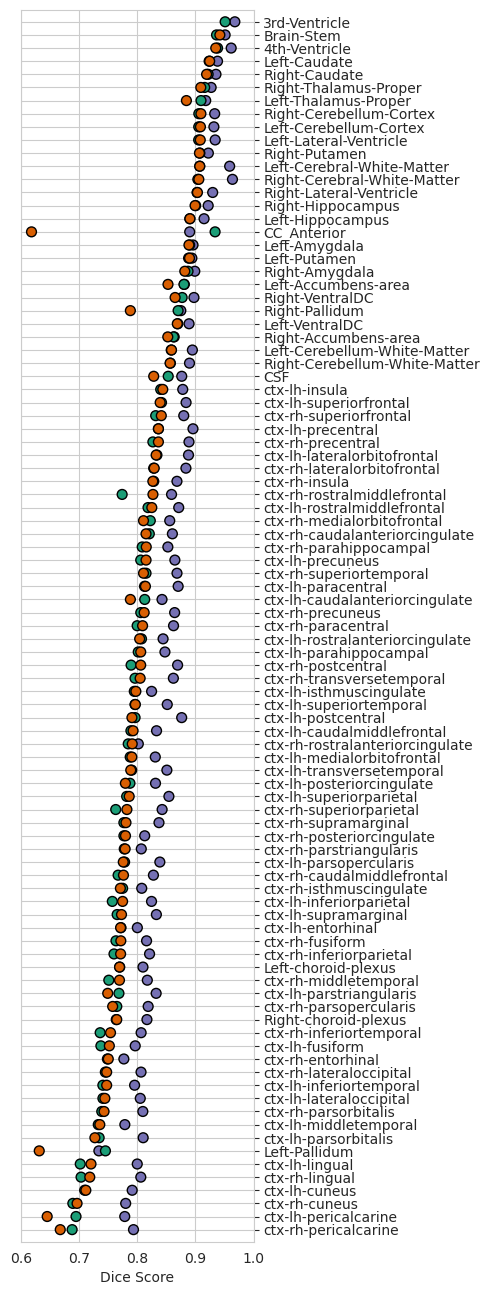

In [228]:
groups = 1
tot = 102
per = math.ceil(tot / groups)
fig, axs = plt.subplots(figsize = (3, 16))
for idx in range(groups):
    idx_L = per * (idx)
    idx_R = per * (idx+1) - 1

    sub2 = df_long.copy() 
    sub2['label_number'] = [label_converter.compressed_to_name(x).item() for x in sub2['label_number']]
    sub2 = sub2.set_index('label_number').loc[order_descending[idx_L:idx_R],:].reset_index(drop=False)
    sub2['method'] = [mapper[x] for x in sub2['method']]
    sub2['label_number'] = pd.Categorical(sub2['label_number'], categories=order_descending[idx_L:idx_R], ordered=True)
    #sub2 = sub2[sub2['label_number'].isin(order_descending[idx_L : idx_R])]
    
    

    
    #fig, axs = plt.subplots(constrained_layout=True, figsize = (4 * 4 / groups, 3))
    
    #sub2 = sub2[sub2['label_number'] <= 5]
    sub2 = sub2.dropna(axis=0, how='any')
    _ = sns.scatterplot(sub2, x='dice_score', y='label_number', hue='method', ax = axs, 
        s=50, edgecolor = 'black', linewidth=1, legend=None, marker='o', alpha=1, palette = my_colors)
    
    #dots = axs.collections[-1]
    #offsets = dots.get_offsets()
    #arr = np.array([np.zeros(offsets.shape[0]), np.random.uniform(0, 0, offsets.shape[0])]).T
    #print(arr.shape)
    #jittered_offsets = offsets + arr
    #dots.set_offsets(jittered_offsets)

    axs.set_yticks(axs.get_yticks(), axs.get_yticklabels(), ha='left')
    axs.yaxis.set_label_position("right")
    axs.yaxis.tick_right()
    axs.set_xlabel('Dice Score')
    axs.set_ylabel('')
    axs.margins(y=0.01)
    #axs.get_xaxis().set_visible(False)
    #axs.grid(False, axis='y')
    #axs.get_yaxis().set_visible(False)
    #axs.set_xlim(xmin=0.0, xmax=1.0)
    #axs.set_ylim(ymin=idx_L-1, ymax=idx_R+1)
    axs.set_xlim(0.6, 1.0)
fig.savefig('/gpfs/home/kn2347/figs/main_analysis_strip_plot.pdf', dpi=300, bbox_inches = 'tight')


### Plots by group

In [84]:
subcortical = ['Left-Caudate', 'Left-Putamen', 'Right-Caudate', 'Right-Putamen', 'Left-Pallidum', 'Right-Pallidum', 'Brain-Stem',
        'Left-Hippocampus', 'Left-Amygdala', 'Left-Accumbens-area', 'Left-VentralDC',
        'Right-Hippocampus', 'Right-Amygdala', 'Right-Accumbens-area', 'Right-VentralDC',
        'Left-choroid-plexus', 'Right-choroid-plexus', 'Left-Thalamus-Proper', 'Right-Thalamus-Proper']
wm = ['Left-Cerebral-White-Matter', 'Right-Cerebral-White-Matter', 
    'Left-Cerebellum-White-Matter', 'Right-Cerebellum-White-Matter', 'Optic-Chiasm']

cortical = ['Left-Cerebellum-Cortex',
    'Right-Cerebellum-Cortex', 'ctx-lh-caudalanteriorcingulate', 'ctx-lh-caudalmiddlefrontal', 'ctx-lh-cuneus',
    'ctx-lh-entorhinal', 'ctx-lh-fusiform', 'ctx-lh-inferiorparietal', 'ctx-lh-inferiortemporal',
    'ctx-lh-isthmuscingulate', 'ctx-lh-lateraloccipital', 'ctx-lh-lateralorbitofrontal', 'ctx-lh-lingual',
    'ctx-lh-medialorbitofrontal', 'ctx-lh-middletemporal', 'ctx-lh-parahippocampal', 'ctx-lh-paracentral',
    'ctx-lh-parsopercularis', 'ctx-lh-parsorbitalis', 'ctx-lh-parstriangularis', 'ctx-lh-pericalcarine',
    'ctx-lh-postcentral', 'ctx-lh-posteriorcingulate', 'ctx-lh-precentral', 'ctx-lh-precuneus',
    'ctx-lh-rostralanteriorcingulate', 'ctx-lh-rostralmiddlefrontal', 'ctx-lh-superiorfrontal', 'ctx-lh-superiorparietal',
    'ctx-lh-superiortemporal', 'ctx-lh-supramarginal', 'ctx-lh-transversetemporal', 'ctx-lh-insula',
    'ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus', 'ctx-rh-entorhinal',
    'ctx-rh-fusiform', 'ctx-rh-inferiorparietal', 'ctx-rh-inferiortemporal', 'ctx-rh-isthmuscingulate',
    'ctx-rh-lateraloccipital', 'ctx-rh-lateralorbitofrontal', 'ctx-rh-lingual', 'ctx-rh-medialorbitofrontal',
    'ctx-rh-middletemporal', 'ctx-rh-parahippocampal', 'ctx-rh-paracentral', 'ctx-rh-parsopercularis',
    'ctx-rh-parsorbitalis', 'ctx-rh-parstriangularis', 'ctx-rh-pericalcarine', 'ctx-rh-postcentral',
    'ctx-rh-posteriorcingulate', 'ctx-rh-precentral', 'ctx-rh-precuneus', 'ctx-rh-rostralanteriorcingulate',
    'ctx-rh-rostralmiddlefrontal', 'ctx-rh-superiorfrontal', 'ctx-rh-superiorparietal', 'ctx-rh-superiortemporal',
    'ctx-rh-supramarginal', 'ctx-rh-transversetemporal', 'ctx-rh-insula'
]

ventricular_or_vessel = [
    '3rd-Ventricle',
    '4th-Ventricle',
    'CSF',
    'Left-Inf-Lat-Vent',
    'Left-Lateral-Ventricle',
    'Left-vessel',
    'Right-Inf-Lat-Vent',
    'Right-Lateral-Ventricle',
    'Right-vessel'
]

cc_regions = [
    'CC_Anterior',
    'CC_Central',
    'CC_Mid_Anterior',
    'CC_Mid_Posterior',
    'CC_Posterior'
]

groups = [wm, cortical, subcortical, ventricular_or_vessel, cc_regions]

def generate_color_map(seed = 2023):
    
    np.random.seed(2023)
    rand_nums = np.random.random((103, 3))
    color_label_mapper = dict()
    for i in range(103):
        color_label_mapper[i] = (rand_nums[i, :] * 255).astype('uint8')
    return color_label_mapper

color_label_mapper = generate_color_map(seed = 2023)

In [86]:
all_regions = wm + cortical + subcortical + ventricular_or_vessel + cc_regions
group_list = ['White-Matter']*len(wm) + ['Cortex']*len(cortical) + ['Subcortex']*len(subcortical) + ['Ventricle_or_Vessel']*len(ventricular_or_vessel) + ['Corpus-Callosum']*len(cc_regions)

def get_hemisphere(region_name):
    if 'lh' in region_name or 'Left' in region_name:
        return 'Left'
    elif 'rh' in region_name or 'Right' in region_name:
        return 'Right'
    else:
        return 'Neither'
def name_without_hemisphere(region_name):
    try_list = ['lh-', 'rh-', 'Left-', 'Right-']
    
    for try_elem in try_list:
        if try_elem in region_name:
            return region_name.replace(try_elem, '')

    # if here, does not have side information
    return region_name

side_list = [get_hemisphere(x) for x in all_regions]
names_without_side = [name_without_hemisphere(x) for x in all_regions]

label_info = pd.DataFrame({'label_number': all_regions, 'name_without_side': names_without_side, 'side': side_list, 'group': group_list})
label_info.to_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/label_info.csv', index=False)

/tmp/ipykernel_2038443/2001165474.py:29: UserWarning: The palette list has more values (64) than needed (4), which may not be intended.
  sns.stripplot(subsub, x='method', y='dice_score', hue='label_number', legend=None, size=5, linewidth=1,
/tmp/ipykernel_2038443/2001165474.py:29: UserWarning: The palette list has more values (64) than needed (19), which may not be intended.
  sns.stripplot(subsub, x='method', y='dice_score', hue='label_number', legend=None, size=5, linewidth=1,
/tmp/ipykernel_2038443/2001165474.py:29: UserWarning: The palette list has more values (64) than needed (5), which may not be intended.
  sns.stripplot(subsub, x='method', y='dice_score', hue='label_number', legend=None, size=5, linewidth=1,


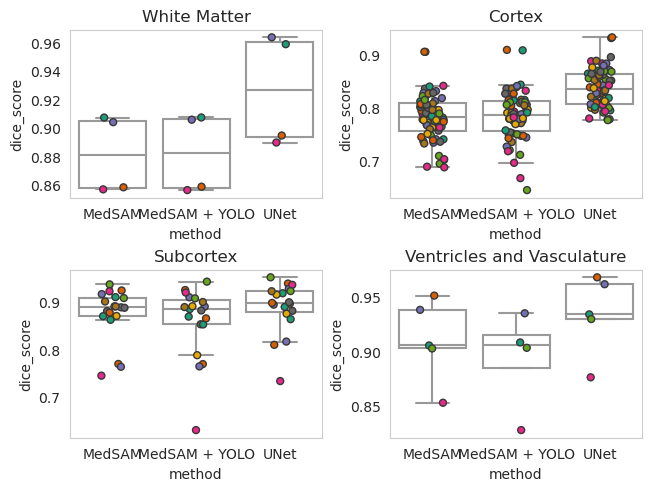

In [ ]:
this_pal = sns.color_palette("Dark2", 64)

df_per_group = main_analysis_df.copy()
df_per_group['label_number'] = [label_converter.compressed_to_name(x).item() for x in df_per_group['label_number']]
order = ['MedSAM', 'MedSAM + YOLO', 'UNet']

r = 2
c = 2
fig, axs = plt.subplots(r, c, constrained_layout=True, squeeze=False)

this_pal = sns.color_palette("Dark2", 64)
for idx, (grp, name) in enumerate(zip(groups, ['White Matter', 'Cortex', 'Subcortex', 'Ventricles and Vasculature'])):
    i = idx // c
    j = idx % c
    subsub = df_per_group[df_per_group['label_number'].isin(grp)].reset_index(drop=True)
    subsub = subsub.merge(label_info, how='left', on='label_number') # now has side, name_without_side, group
    subsub = subsub[subsub['dice_score'] >= 0.5].reset_index(drop=True)

    # create a color palette to use
    unq_names = np.unique(subsub['name_without_side']).tolist()
    dicto = {}
    this_palette = sns.color_palette(cc.glasbey, n_colors=len(unq_names))
    for idxx, zz in enumerate(unq_names):
        dicto[zz] = this_palette[idxx]

    sns.boxplot(subsub, x='method', y='dice_score', palette=['white'] * subsub['method'].nunique(),
        order = order, ax = axs[i,j], showfliers=False)
    
    sns.stripplot(subsub, x='method', y='dice_score', hue='label_number', legend=None, size=5, linewidth=1,
        order=order, jitter = 0.15, ax = axs[i,j], palette = this_pal)

    axs[i,j].set_title(name)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MedSAM vs. MedSAM + YOLO: t-test paired samples, P_val:4.381e-01 t=-8.919e-01
MedSAM + YOLO vs. UNet: t-test paired samples, P_val:4.864e-03 t=-7.525e+00
MedSAM vs. UNet: t-test paired samples, P_val:5.618e-03 t=-7.157e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MedSAM vs. MedSAM + YOLO: t-test paired samples, P_val:6.863e-02 t=-1.853e+00
MedSAM + YOLO vs. UNet: t-test paired samples, P_val:4.280e-29 t=-2.010e+01
MedSAM vs. UNet: t-test paired samples, P_val:1.863e-32 t=-2.310e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
   

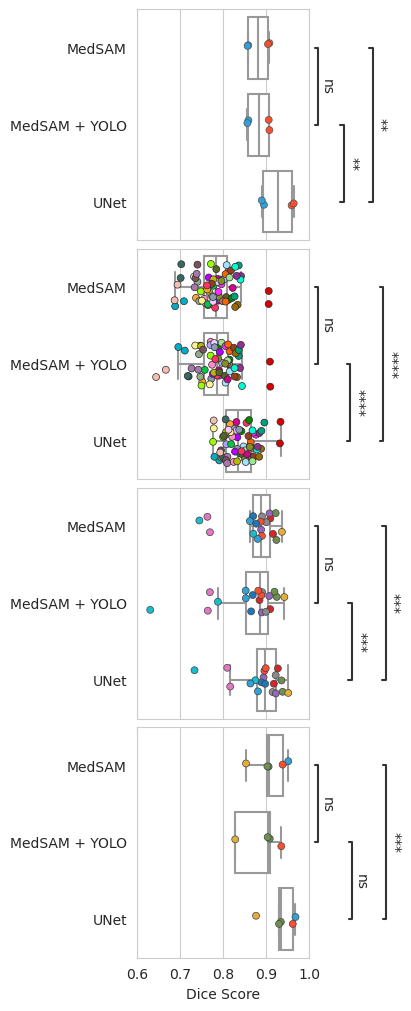

In [312]:

df_per_group = main_analysis_df.copy()
df_per_group['label_number'] = [label_converter.compressed_to_name(x).item() for x in df_per_group['label_number']]
order = ['MedSAM', 'MedSAM + YOLO', 'UNet']

r = 4
c = 1
fig, axs = plt.subplots(r, c, constrained_layout=True, squeeze=False, sharey=True, sharex=True, figsize = (4, 10))

jitters = [0.075, 0.3, 0.2, 0.075]
palettes = [cc.glasbey_hv, cc.glasbey_light, cc.glasbey_hv, cc.glasbey_hv]

for idx, (grp, name) in enumerate(zip(groups, ['White Matter', 'Cortex', 'Subcortex', 'Ventricles and Vasculature'])):
    i = idx // c
    j = idx % c
    subsub = df_per_group[df_per_group['label_number'].isin(grp)].reset_index(drop=True)
    subsub = subsub.merge(label_info, how='left', on='label_number') # now has side, name_without_side, group
    subsub = subsub[subsub['dice_score'] >= 0.01].reset_index(drop=True)

    # create a color palette to use
    unq_names = np.unique(subsub['name_without_side']).tolist()
    dicto = {}
    #this_palette = sns.color_palette(cc.glasbey, n_colors=len(unq_names))
    this_palette = sns.color_palette(palettes[idx], n_colors=len(unq_names))
    for idxx, zz in enumerate(unq_names):
        dicto[zz] = this_palette[idxx]


    subsub['method'] = pd.Categorical(subsub['method'], categories = order, ordered = True)

    sns.boxplot(subsub, y='method', x='dice_score', palette=['white'] * subsub['method'].nunique(),
        ax = axs[i,j], showfliers=False)

    sns.stripplot(subsub, y='method', x='dice_score', hue='name_without_side', legend=None, size=5, linewidth=0.5, 
        jitter = jitters[idx], ax = axs[i,j], palette = dicto)

    if idx == r*c-1:
        axs[i,j].set_xlabel('Dice Score')
    else:
        axs[i,j].set_xlabel('')
    axs[i,j].set_ylabel('')

    # add statistical tests
    annotator = Annotator(axs[i,j], 
        pairs = [
            (order[0], order[1]),
            (order[1], order[2]),
            (order[0], order[2])
        ], 
        data=subsub, 
        x='dice_score', 
        y='method', 
        order=order,
        orient='h'
    )
    annotator.configure(test='t-test_paired', text_format='star', loc='outside')

    axs[i,j].set_xlim(0.6, 1)
    annotator.apply_and_annotate()  

fig.savefig('/gpfs/home/kn2347/figs/main_analysis_grouped.pdf', dpi=300)
    

    #axs[i,j].set_xticks(order, order, rotation=90, ha='right', fontsize=9)

    #sns.swarmplot(subsub, x='method', y='dice_score', hue='name_without_side', legend=None, size=5, linewidth=1,
    #    ax = axs[i,j], palette = dicto)

    #axs[i,j].set_title(name)

### Runtime Comparison

MedSAM: 123.90460219975391 +/- 43.87474720728317
MedSAM + YOLO: 76.94731126015948 +/- 43.85565700315748
UNet: 135.38020190338884 +/- 40.63352772873803


ValueError: unequal length arrays

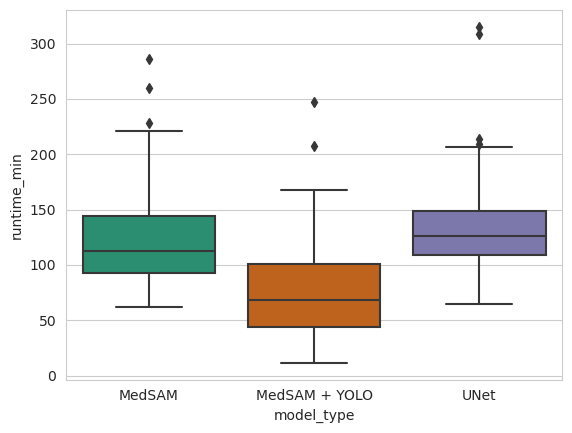

In [ ]:
runtime_df = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_training_runtimes_12-17-24/training_runtimes.csv')
runtime_df['runtime_min'] = runtime_df['runtime']/60.0

# remove outliers
runtime_df = runtime_df[runtime_df['runtime_min'] < 500].reset_index(drop=True) # excluded is one outlier run (label 4) by UNet in which CPU was used instead of GPU
#runtime_df = runtime_df[runtime_df['label'] != 4].reset_index(drop=True)

# compute mean and standard deviation
sub1 = runtime_df[runtime_df['model_type'] == 'MedSAM']['runtime_min']
print(f'MedSAM: {np.mean(sub1)} +/- {np.std(sub1)}')

sub1 = runtime_df[runtime_df['model_type'] == 'MedSAM + YOLO']['runtime_min']
print(f'MedSAM + YOLO: {np.nanmean(sub1)} +/- {np.nanstd(sub1)}')

sub1 = runtime_df[runtime_df['model_type'] == 'UNet']['runtime_min']
print(f'UNet: {np.mean(sub1)} +/- {np.std(sub1)}')

# Create a boxplot
fig, axs = plt.subplots()
sns.boxplot(runtime_df, x = 'model_type', y='runtime_min', palette = my_colors, ax = axs)

# add statistical tests
annotator = Annotator(axs, 
    pairs = [
        ('MedSAM', 'UNet')
    ], 
    data=runtime_df, 
    x='model_type', 
    y='runtime', 
    order=['MedSAM', 'UNet']
)

annotator.configure(test='t-test_paired', text_format='star', loc='outside')
annotator.apply_and_annotate()  

axs.set_xlabel('Method')
axs.set_ylabel('Runtime (min)')

## Subset Analysis

In [8]:
def collect_df_repeat(pattern):
    listo = glob(pattern)

    collector = {'label_number': [], 'pct_dataset': [], 'repeat': [], 'dice_sensitivity': [], 'dice_specificity': [], 'overall_dice': []}
    for x in listo:
        label = int(x.split('/')[-5])
        frac = int(x.split('/')[-4])
        repeat = int(x.split('/')[-3])
        #this_pkl = torch.load(x, map_location=torch.device('cpu'))
        with open(x, 'rb') as file:
            this_pkl = CPU_Unpickler(file).load()

        collector['label_number'].append(label)
        collector['pct_dataset'].append(frac)
        collector['repeat'].append(repeat)
        collector['dice_sensitivity'].append(this_pkl['dice_sensitivity'].item())
        collector['dice_specificity'].append(this_pkl['dice_specificity'].item())
        collector['overall_dice'].append(this_pkl['overall_dice'].item())


    total_df = pd.DataFrame(collector)
    total_df = total_df.sort_values(by = ['label_number', 'pct_dataset', 'repeat']).reset_index(drop=True)
    return total_df


#pattern1 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_analysis_11-12-24/UNet/val/0.0005/*/*/*/at_least_100/eval_singletask_unet_val_label*.pkl'
pattern1 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_analysis_11-12-24/UNet/test/0.0005/*/*/*/at_least_100/*.pkl'
unet_df = collect_df_repeat(pattern1)
unet_df['model'] = 'UNet'

#pattern2 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_analysis_11-12-24/MedSAM/val/0.0005/*/*/*/at_least_100/eval_singletask_unprompted_val_label*.pkl'
pattern2 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_analysis_11-12-24/MedSAM/test/0.0005/*/*/*/at_least_100/*.pkl'
medsam_df = collect_df_repeat(pattern2)
medsam_df['model'] = 'MedSAM'

pattern3 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_analysis_11-12-24/MedSAM_Oracle/test/0.0005/*/*/*/at_least_100/eval_singletask_yolov7_prompted_test_label*.pkl'
medsam_oracle_df = collect_df_repeat(pattern3)
medsam_oracle_df['model'] = 'MedSAM Oracle'

total_df = pd.concat([medsam_df, medsam_oracle_df, unet_df], ignore_index=True)


In [9]:
# filter out the outlier repeats by removing repeats that have dice score lower than median_for_that_(label, pct_dataset, model)_tuple - 0.30 (i.e. if the median is 0.8, then any repeats with lower than 0.5 would be dropped)

filtered_df = total_df.copy()
zz = filtered_df.groupby(['label_number', 'pct_dataset', 'model']).agg(
    {
        'dice_sensitivity': lambda x: np.quantile(x,0.5) - 0.30
    }
).reset_index(drop=False)

filtered_df = filtered_df.merge(zz, how='left', on=['label_number', 'pct_dataset', 'model'], suffixes=['','_threshold'])
filtered_df = filtered_df[filtered_df['dice_sensitivity'] >= filtered_df['dice_sensitivity_threshold']]
filtered_df = filtered_df.reset_index(drop=True)

# generate median df
median_df = filtered_df.groupby(['label_number', 'pct_dataset', 'model']).agg({'dice_sensitivity': 'median'}).reset_index(drop=False)

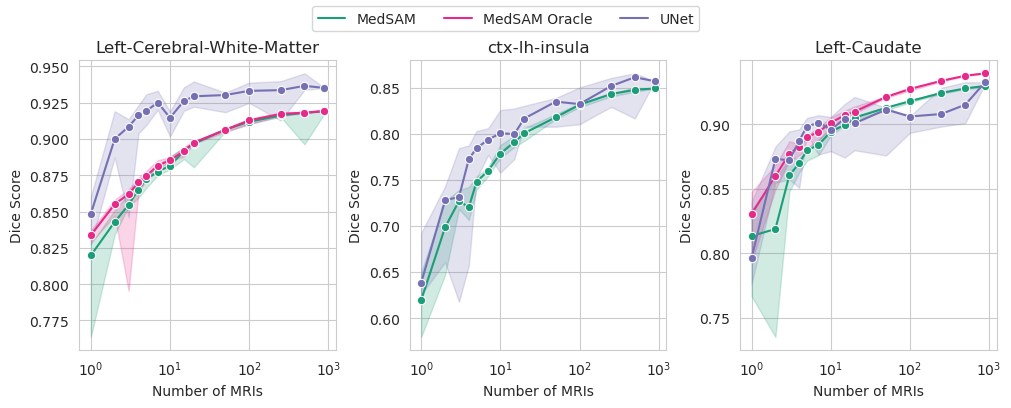

In [11]:
r = 1
c = 3
fig, axs = plt.subplots(r,c, layout='constrained', sharex=True, squeeze=False,  figsize = (10, 4))
labels = [1,71,7]

#g = sns.FacetGrid(total_df, col = 'label_number', hue = 'model', col_wrap=4)
for idx, lab in enumerate(labels):
    i = idx // c
    j = idx % c
    
    xx = sns.lineplot(filtered_df[filtered_df['label_number'] == lab], x = 'pct_dataset', y = 'dice_sensitivity', hue = 'model', marker='o', ax = axs[i,j],
        estimator='median', legend = True if (i,j) == (0,0) else False, err_style='band', errorbar=('ci', 95),
        palette = my_colors)
    axs[i,j].set_xscale('log')
    axs[i,j].set_xlabel('Number of MRIs')
    axs[i,j].set_ylabel('Dice Score')
    axs[i,j].set_title(f'{label_converter.compressed_to_name(lab)}')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="outside upper center", ncol=3)
axs[0,0].get_legend().remove()

#fig.savefig('/gpfs/home/kn2347/figs/subset_analysis_medsam_vs_unet_test.pdf', dpi=300)

In [241]:
total_df[(total_df['label_number'] == 7) & (total_df['pct_dataset'] == 50)]

,label_number,pct_dataset,repeat,dice_sensitivity,dice_specificity,overall_dice,model
185,7,50,0,0.911028,9.934406e-01,0.985741,MedSAM
186,7,50,1,0.913161,9.919517e-01,0.984590,MedSAM
187,7,50,2,0.004616,1.525879e-11,0.000431,MedSAM
188,7,50,3,0.913554,9.923944e-01,0.985028,MedSAM
189,7,50,4,0.912687,9.875252e-01,0.980533,MedSAM
395,7,50,0,0.920765,1.000000e+00,0.992597,MedSAM Oracle
396,7,50,1,0.920647,1.000000e+00,0.992586,MedSAM Oracle
397,7,50,2,0.921379,1.000000e+00,0.992654,MedSAM Oracle
398,7,50,3,0.921915,1.000000e+00,0.992705,MedSAM Oracle
399,7,50,4,0.921601,1.000000e+00,0.992675,MedSAM Oracle
